#  <font color=green>Credit Card Fraud Detection Project</font>

##### Hello!

##### I am really excited about machine-learning and decided to take on this project as the first of many to get more comfortable with the models used. 

##### This project covers credit card fraud and is meant to look at a dataset of transactions and predict whether it is fraudulent or not. 

### Imports 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

### Reading the Data

In [2]:
data = pd.read_csv('creditcard.csv')

### Explore the Data

In [3]:
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [4]:
data.shape

(284807, 31)

In [5]:
# random_state helps assure that you always get the same output when you split the data
# this helps create reproducible results and it does not actually matter what the number is
# frac is percentage of the data that will be returned
data = data.sample(frac = 0.2, random_state = 1)
print(data.shape)

(56961, 31)


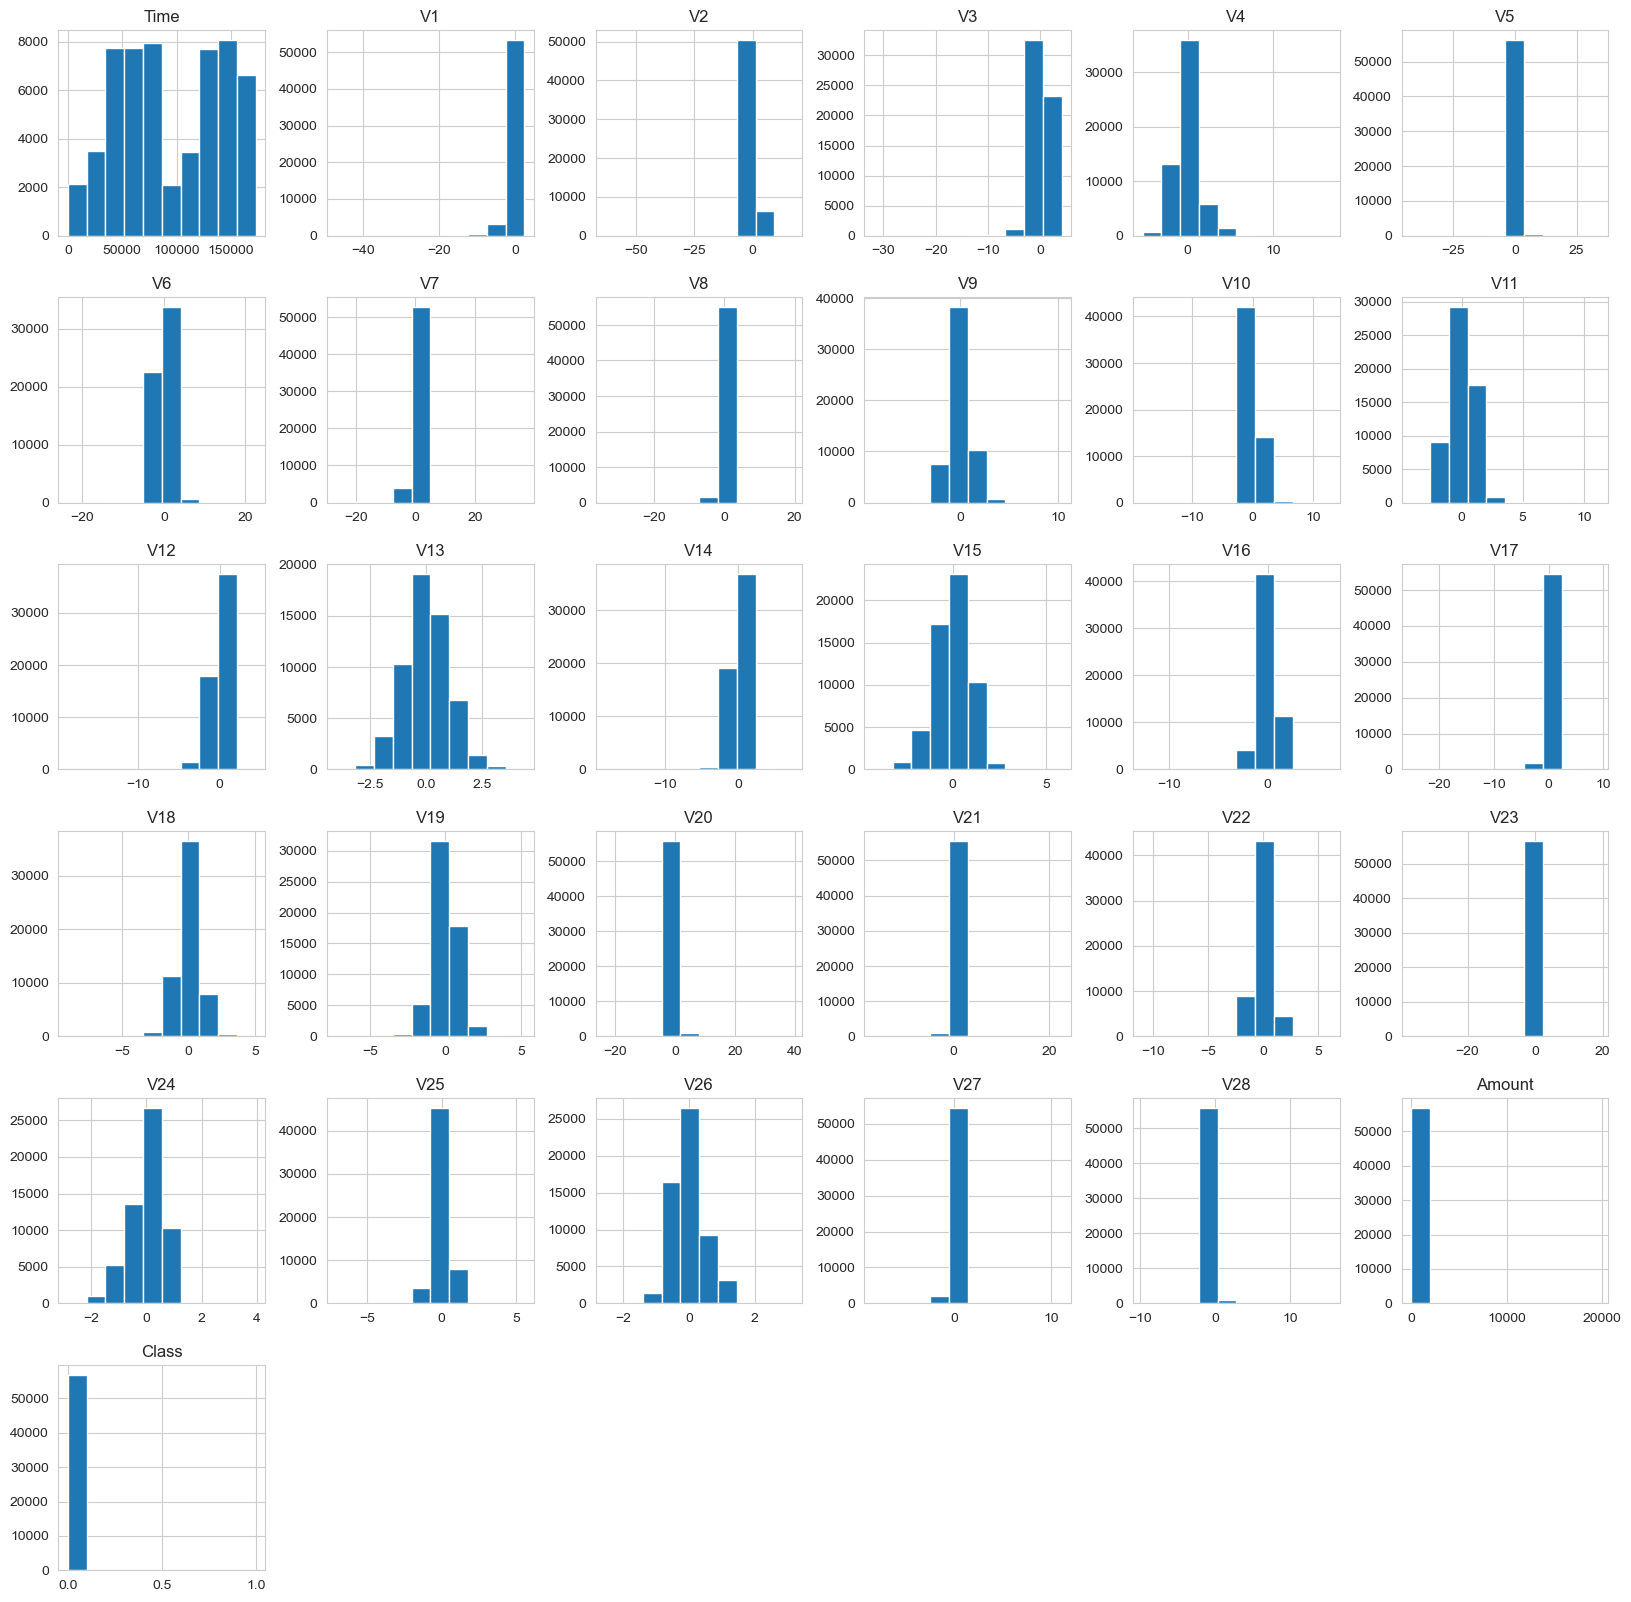

In [6]:
# plot the histogram of each parameter
data.hist(figsize = (20, 20))
plt.show()

##### You can see most of the V's are clustered around 0 with some or no outliers. Notice we have very few fraudulent cases over valid cases in our class histogram.

In [7]:
# determine the number of fraud cases
fraud = data[data['Class'] == 1]
valid = data[data['Class'] == 0]

outlier_fraction = len(fraud) / float(len(valid))
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(fraud)))
print('Valid Cases: {}'.format(len(valid)))

0.0015296972254457222
Fraud Cases: 87
Valid Cases: 56874


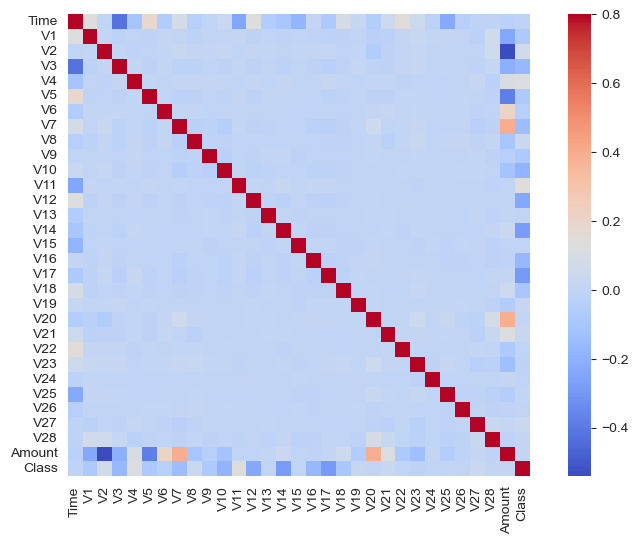

In [8]:
# correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (10, 6))

sns.heatmap(corrmat, vmax = .8, square = True, cmap = 'coolwarm')
plt.show()

##### You can see a lot of the values are close to 0 . Most of them are fairly unrelated. The lighter squares signify a stronger correlation. 

### Organizing the Data

In [9]:
# get the columns from the dataframe
columns = data.columns.tolist()

# filter the columns to remove the data we do not want
columns = [col for col in columns if col not in ['Class']]

# store the variable we will be predicting on which is class
target = 'Class'

# X includes everything except our class column
X = data[columns]
# Y includes all the class labels for each sample
# this is also one-dimensional
Y = data[target]

# print the shapes of X and Y
print(X.shape)
print(Y.shape)

(56961, 30)
(56961,)


### Applying Algorithms

In [10]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [11]:
# define a random state
state = 1

# define the outlier detection methods
classifiers = {
    # contamination is the number of outliers we think there are
    'Isolation Forest': IsolationForest(max_samples = len(X),
                                       contamination = outlier_fraction,
                                       random_state = state),
    # number of neighbors to consider, the higher the percentage of outliers the higher you want to make this number
    'Local Outlier Factor': LocalOutlierFactor(
    n_neighbors = 20,
    contamination = outlier_fraction)
}

### Fit the Model

In [12]:
n_outliers = len(fraud)

Iso_pred = object()
LOF_pred = object()

Iso_score = object()
LOF_score = object()

for i, (clf_name, clf) in enumerate(classifiers.items()):

    # fit the data and tag outliers
    if clf_name == 'Local Outlier Factor':
        LOF_pred = clf.fit_predict(X)
        LOF_score = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        Iso_score = clf.decision_function(X)
        Iso_pred = clf.predict(X)

##### Use Metrics to Evaluate Model Performance.

In [13]:
# reshape the prediction values to 0 for valid and 1 for fraud
Iso_pred[Iso_pred == 1] = 0
Iso_pred[Iso_pred == -1] = 1

# calculate the number of errors
n_errors = (Iso_pred != Y).sum()

# classification matrix
print('Local Outlier Factor : {}'.format(n_errors))
print('Accuracy : ', accuracy_score(Y, Iso_pred))
print(classification_report(Y, Iso_pred))

Local Outlier Factor : 127
Accuracy :  0.997770404311722
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.27      0.28      0.27        87

    accuracy                           1.00     56961
   macro avg       0.64      0.64      0.64     56961
weighted avg       1.00      1.00      1.00     56961



In [14]:
# reshape the prediction values to 0 for valid and 1 for fraud
LOF_pred[LOF_pred == 1] = 0
LOF_pred[LOF_pred == -1] = 1

# calculate the number of errors
n_errors = (LOF_pred != Y).sum()

# classification matrix
print('Local Outlier Factor : {}'.format(n_errors))
print('Accuracy : ', accuracy_score(Y, LOF_pred))
print(classification_report(Y, LOF_pred))

Local Outlier Factor : 173
Accuracy :  0.9969628342199048
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56874
           1       0.01      0.01      0.01        87

    accuracy                           1.00     56961
   macro avg       0.50      0.50      0.50     56961
weighted avg       1.00      1.00      1.00     56961



##### Looking at precision for fraudulent cases (1) lets us know the percentage of cases that are getting correctly labeled. 'Precision' accounts for false-positives. 'Recall' accounts for false-negatives. Low numbers could mean that we are constantly calling clients asking them if they actually made the transaction which could be annoying.

##### Goal: To get better percentages.

##### Our Isolation Forest method (which is Random Forest based) was able to produce a better result. Looking at the f1-score 26% (or approx. 30%) of the time we are going to detect the fraudulent transactions.